<a href="https://colab.research.google.com/github/irravasyuk/SQL_2/blob/master/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D0%BA%D0%BB%D0%B0%D1%81%D0%B8%D1%84%D1%96%D0%BA%D1%96%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [13]:
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

Дані про діабет

In [14]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/Healthcare-Diabetes.csv',
                 index_col='Id')

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [15]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.000000,0.416873,0.234415,0.483333,1
2,0.058824,0.427136,0.540984,0.263636,0.000000,0.330025,0.116567,0.166667,0
3,0.470588,0.919598,0.524590,0.000000,0.000000,0.289082,0.253629,0.183333,1
4,0.058824,0.447236,0.540984,0.209091,0.111111,0.348635,0.038002,0.000000,0
5,0.000000,0.688442,0.327869,0.318182,0.198582,0.534739,0.943638,0.200000,1


Потрібно на основі інформації пацієнта виявити наявність діабету `Outcome`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [16]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [17]:
X = df.drop("Outcome", axis='columns')
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

In [18]:
dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)


# Завдання 2
Створіть DataLoader

In [19]:
from torch.utils.data import DataLoader

batch_size = 64
train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      shuffle=True)

test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True)

# Завдання 3
Створіть нейромережу

In [20]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.sigmoid(out)
        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = BinaryClassifier(8, 40, 1).to(device)
model


BinaryClassifier(
  (linear1): Linear(in_features=8, out_features=40, bias=True)
  (linear2): Linear(in_features=40, out_features=1, bias=True)
)

In [21]:
from torchsummary import summary

summary(model, input_size=(8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]             360
            Linear-2                    [-1, 1]              41
Total params: 401
Trainable params: 401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [22]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr= 1e-2)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [23]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=20,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=SGD(lr=0.010000), epochs=20, device=cpu

Epoch    1    0sec	loss:      0.665	val_loss:      0.661	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.223	val_roc_auc_score:      0.255	
Epoch    2    0sec	loss:       0.66	val_loss:      0.657	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.221	val_roc_auc_score:      0.255	
Epoch    3    0sec	loss:      0.657	val_loss:      0.655	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.218	val_roc_auc_score:       0.26	
Epoch    4    0sec	loss:      0.655	val_loss:      0.653	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.221	val_roc_auc_score:      0.272	
Epoch    5    0sec	loss:      0.653	val_loss:      0.652	accuracy_score:      0.656	val_accuracy_score:      0.655	roc_auc_score:      0.233	val_roc_auc_score:       0.28	
Epoch    6    0sec	loss:      0.652	val_loss:      0.65

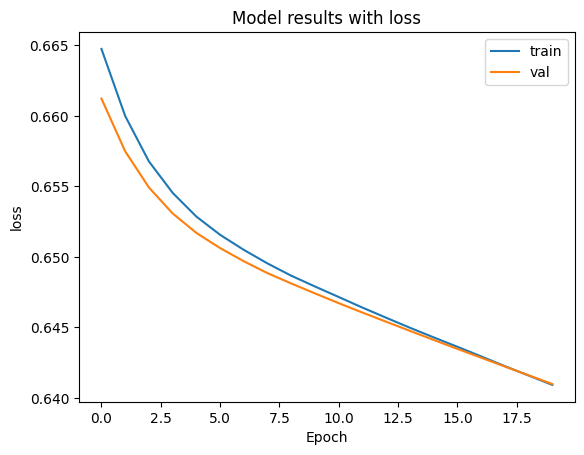

In [29]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

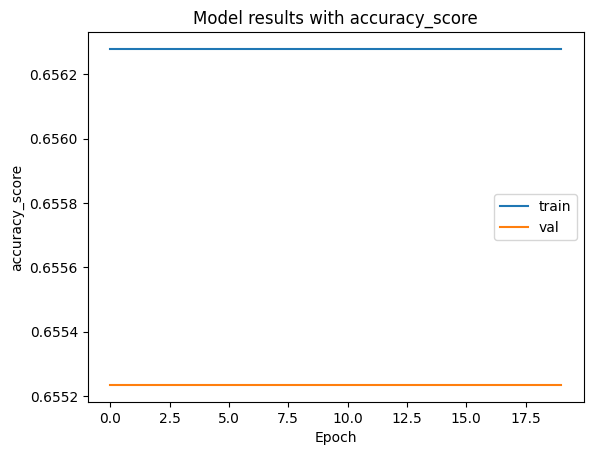

In [30]:
plot_metric(history, 'accuracy_score')

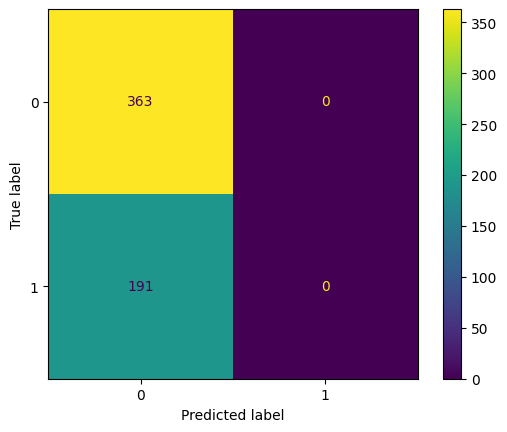

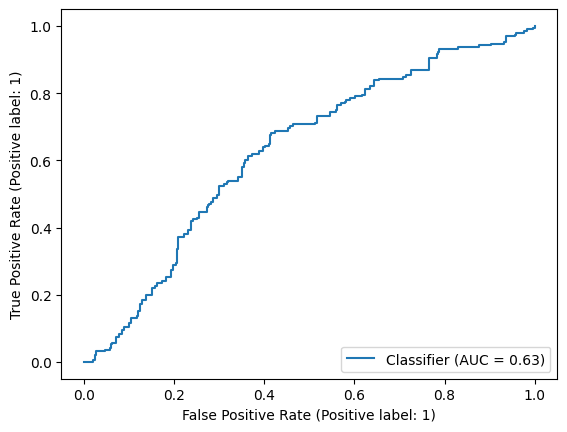

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')  # відключаємо від gpu
y_pred = model.predict(X_test, device)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [32]:
torch.save(model, 'model.pt')

In [33]:
load_model = torch.load('model.pt')

In [34]:
load_model

BinaryClassifier(
  (linear1): Linear(in_features=8, out_features=40, bias=True)
  (linear2): Linear(in_features=40, out_features=1, bias=True)
)

In [35]:
X.iloc[:1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Id,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.0,0.416873,0.234415,0.483333


In [36]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.3529, 0.7437, 0.5902, 0.3182, 0.0000, 0.4169, 0.2344, 0.4833]])
torch.Size([1, 8])


In [37]:
load_model(X_data)

tensor([[0.3649]], grad_fn=<SigmoidBackward0>)